
<br>
Clothing Retail Sales -Seasonality Analysis & Forecasting With Recurrent Neural Networks -RNN :<br>


In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

 Using Parse_Date=True , pandas will automatically detect date column as datetime object :

In [59]:
df=pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')

In [60]:
print(df.head())

            RSCCASN
DATE               
1992-01-01     6938
1992-02-01     7524
1992-03-01     8475
1992-04-01     9401
1992-05-01     9558


In [61]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB
None


In [62]:
df.columns=['Sales']

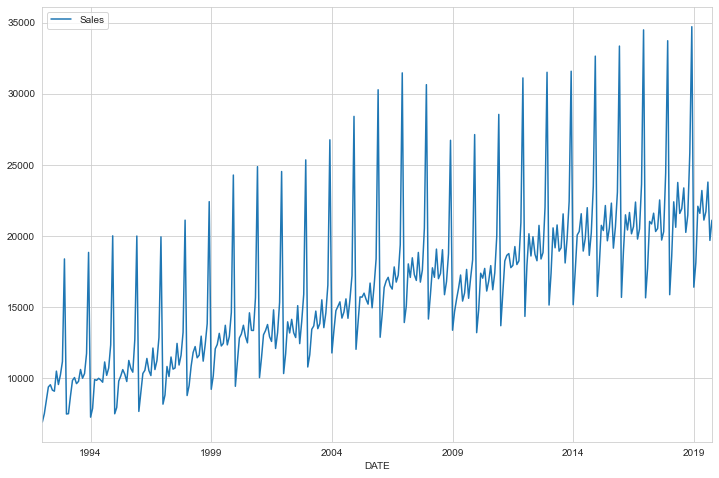

In [63]:
sns.set_style('whitegrid')
df.plot(figsize=(12,8))
plt.show()


 <br>
Determining Train / Test Split Index :<br>


In [64]:
print(len(df))

334


In [65]:
print(len(df)-18)

316


In [66]:
test_size=18

In [67]:
test_ind=len(df)-test_size

In [68]:
print(test_ind)

316



 <br>
Here , For forecasting we should train our model for atleast a year 's cycle , in order to get it familiar with<br>
the seasonality of sales..For simplicity , i will be taking 18 as test size , since 18 months = 1.5 years<br>
and before that , rest of the data will be my training data :<br>


In [69]:
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [70]:
print(train)

            Sales
DATE             
1992-01-01   6938
1992-02-01   7524
1992-03-01   8475
1992-04-01   9401
1992-05-01   9558
...           ...
2017-12-01  33720
2018-01-01  15881
2018-02-01  18585
2018-03-01  22404
2018-04-01  20616

[316 rows x 1 columns]


In [71]:
print(test)

            Sales
DATE             
2018-05-01  23764
2018-06-01  21589
2018-07-01  21919
2018-08-01  23381
2018-09-01  20260
2018-10-01  21473
2018-11-01  25831
2018-12-01  34706
2019-01-01  16410
2019-02-01  18134
2019-03-01  22093
2019-04-01  21597
2019-05-01  23200
2019-06-01  21123
2019-07-01  21714
2019-08-01  23791
2019-09-01  19695
2019-10-01  21113



 <br>
SCALING OF DATA :<br>


In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [73]:
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)


 <br>
TimeSeriesGenerator :<br>
For validation test set generator my batch size must be less than test size , i.e. , 18 , in order<br>
to run properly without error. I would be taking my length of batch as 12 , because it is one whole <br>
year..<br>


In [74]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [75]:
length=12

In [76]:
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [77]:
X,y=generator[0]

In [78]:
print(X)
print(y)
print(scaled_train[13])

[[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]
[[0.02047633]]
[0.02127505]



 <br>
CREATING MODEL:<br>


In [79]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential

In [80]:
n_features=1     #Sales column

In [81]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [82]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [85]:
validation_gen=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)
model.fit_generator(generator,epochs=20,validation_data=validation_gen,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0256 - val_loss: 0.0111
Epoch 2/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0164 - val_loss: 0.0026
Epoch 3/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 4/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0061 - val_loss: 9.3760e-04
Epoch 5/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 3.8521e-04
Epoch 6/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0023 - val_loss: 0.0067
Epoch 7/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0026 - val_loss: 3.4585e-04
Epoch 8/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0021 - val_loss: 3.9703e-04
Epoch 9/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 4.0008e-04


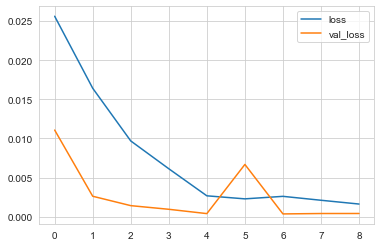

In [86]:
losses=pd.DataFrame(model.history.history)
losses.plot()
plt.show()

In [87]:
test_predictions=[]

In [88]:
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)

In [89]:
for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [90]:
true_pred=scaler.inverse_transform(test_predictions)

In [91]:
df2=test.copy()
df2['Predictions']=true_pred

In [92]:
print(df2)

            Sales   Predictions
DATE                           
2018-05-01  23764  21408.439995
2018-06-01  21589  20380.654211
2018-07-01  21919  20649.389861
2018-08-01  23381  22398.077247
2018-09-01  20260  20048.578192
2018-10-01  21473  20648.938380
2018-11-01  25831  24250.894289
2018-12-01  34706  33895.108732
2019-01-01  16410  16166.212967
2019-02-01  18134  18490.879727
2019-03-01  22093  22021.305395
2019-04-01  21597  20424.243504
2019-05-01  23200  21226.179440
2019-06-01  21123  20426.942541
2019-07-01  21714  20732.884358
2019-08-01  23791  22270.662645
2019-09-01  19695  20301.493114
2019-10-01  21113  20939.004471


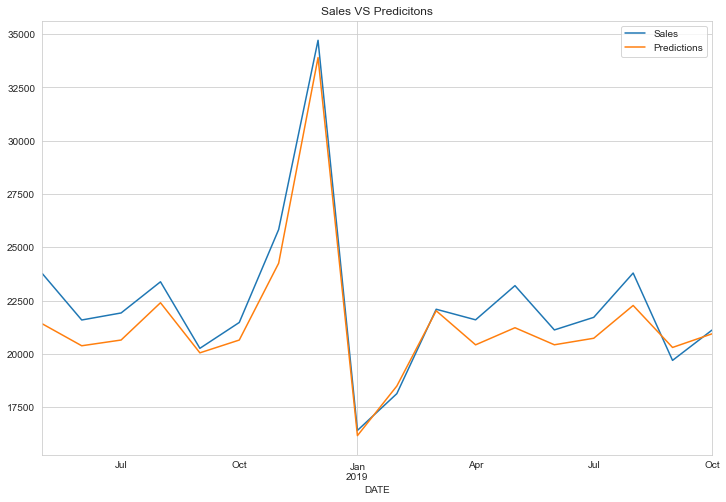

In [93]:
df2.plot(figsize=(12,8))
plt.title('Sales VS Predicitons')
plt.show()


 <br>
FORECASTING VALUES INTO UNKNOWN FUTURE By USING FULL DATASET AS TRAINING:<br>


In [94]:
full_Scaler=MinMaxScaler()

In [95]:
full_scaled_data=full_Scaler.fit_transform(df)  #Transforming Full Data :

In [96]:
length=12

In [97]:
generator=TimeseriesGenerator(full_scaled_data,full_scaled_data,length=length,batch_size=1)

In [98]:
model=Sequential()

In [99]:
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [100]:
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0236
Epoch 2/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0196
Epoch 3/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0147
Epoch 4/8
322/322 [==============================] - 4s 13ms/step - loss: 0.0091
Epoch 5/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0039
Epoch 6/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0027
Epoch 7/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0017
Epoch 8/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0016



<br>
periods is the number of months we want to predict , so here i took 12 , as i want to predict<br>
next 12 months forecast.You can take any number you want .. but do remember , longer the length<br>
of period , more will be the noisy data....<br>
SO it would be much better if you choose the same length for periods as <br>
the length of your test size , i.e. , 12..<br>


In [101]:
forecast=[]
periods=12

In [102]:
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)

In [103]:
for i in range(periods):
    current_pred=model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    
forecast_pred=full_Scaler.inverse_transform(forecast)

In [104]:
print(df)
print(forecast_pred)

            Sales
DATE             
1992-01-01   6938
1992-02-01   7524
1992-03-01   8475
1992-04-01   9401
1992-05-01   9558
...           ...
2019-06-01  21123
2019-07-01  21714
2019-08-01  23791
2019-09-01  19695
2019-10-01  21113

[334 rows x 1 columns]
[[21821.4232769 ]
 [20699.72770119]
 [20965.19444036]
 [22809.05726385]
 [20278.88000727]
 [20934.3847208 ]
 [24977.08832121]
 [34414.09797525]
 [16611.03792548]
 [18994.0104301 ]
 [22499.23048687]
 [20892.5404377 ]]


ou can see that forecast_pred values are actually values predicted after the dataframe's values


 <br>
Now let us create a proper dataframe with comparisons..<br>
we have to create new timestamp range for future predictions<br>



 <br>
pd.date_Range will create automatically new dates with intervals , start parameter will take the <br>
starting point , one after our original dataframe , periods is intervals , i.e., 12[already defined <br>
into periods variable], freq=offset aliases MS -> monthly sequence intervals<br>


In [105]:
forecast_index=pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [106]:
print(forecast_index)

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')


In [107]:
forecast_Df=pd.DataFrame(data=forecast_pred,index=forecast_index,columns=['Forecast'])

In [108]:
print(forecast_Df)

                Forecast
2019-11-01  21821.423277
2019-12-01  20699.727701
2020-01-01  20965.194440
2020-02-01  22809.057264
2020-03-01  20278.880007
2020-04-01  20934.384721
2020-05-01  24977.088321
2020-06-01  34414.097975
2020-07-01  16611.037925
2020-08-01  18994.010430
2020-09-01  22499.230487
2020-10-01  20892.540438


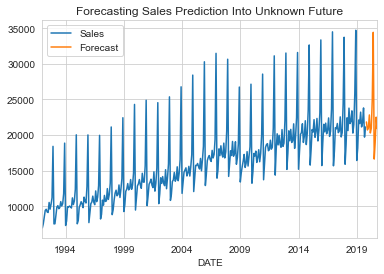

In [109]:
ax=df.plot()

forecast_Df.plot(ax=ax)
plt.title("Forecasting Sales Prediction Into Unknown Future")
plt.show()

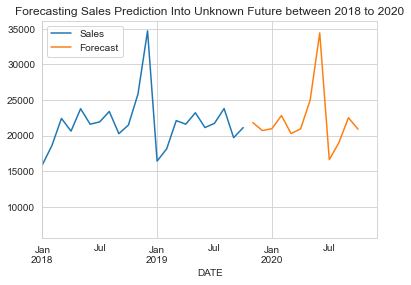

In [110]:
ax=df.plot()
forecast_Df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')  #Zoom our graph into mentioned X - AXIS Values
plt.title("Forecasting Sales Prediction Into Unknown Future between 2018 to 2020")
plt.show()